<a href="https://colab.research.google.com/github/fallahtafti-ahmad/GDDPM/blob/main/Demo_GDDPM_on_renew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/AmirMiraki/GDDPM.git

Cloning into 'GDDPM'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 0), reused 16 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 7.47 MiB | 15.64 MiB/s, done.


In [ ]:
!cp -R /content/GDDPM/Algorithm ./Algorithm

In [ ]:
!pip install torch==2.3.0
!pip install CRPS
import torch
print(torch.__version__,torch.version.cuda)

In [ ]:
!python -m pip install pip==23
!pip install pytorchts lightning
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install gluonts==0.9.9

In [ ]:
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from Algorithm import GDDPMEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [ ]:
import pandas as pd
X_f = pd.read_csv("/content/GDDPM/Data/Renew.csv",index_col='Time',parse_dates=True).resample('1h').mean()
time_length = X_f.shape[0]
num_nodes = X_f.shape[1]-3
test_length = round(0.2 * time_length)
val_length = round(0.2 * time_length)
train_length = time_length - val_length - test_length
start = pd.Period(X_f.index[0],freq="10min")
X = X_f.to_numpy().T
A = np.ones((num_nodes,num_nodes))
edge_index = np.nonzero(A)
edge_weight = np.float32(A[edge_index])
from gluonts.dataset.common import ListDataset
train_ds = ListDataset([{"target": x, "start": X_f.index[0]} for x in X[3:, :-(val_length + test_length)]],freq="1h")
val_ds = ListDataset([{"target": x, "start": X_f.index[-(val_length + test_length)]} for x in X[3:, -(val_length + test_length): -test_length]],freq="1h")
test_ds = ListDataset([{"target": x, "start": X_f.index[-test_length]} for x in X[3:, -( test_length):]],freq="1h")

In [ ]:
X_f.head()

,Unnamed: 0,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
Time,,,,,,,,,,,,
2019-01-01 00:00:00,5.5,1.0,1.0,0.0,0.0,0.0,2.838333,55.809333,1.683333,0.0,2812.083333,21851.416667
2019-01-01 01:00:00,17.5,1.0,1.0,0.0,0.0,0.0,2.770000,55.159000,1.405000,0.0,2499.500000,21099.666667
2019-01-01 02:00:00,29.5,1.0,1.0,0.0,0.0,0.0,2.690000,54.532833,1.186667,0.0,2387.083333,20495.416667
2019-01-01 03:00:00,41.5,1.0,1.0,0.0,0.0,0.0,2.655000,54.317833,0.985000,0.0,2369.333333,20147.500000
2019-01-01 04:00:00,53.5,1.0,1.0,0.0,0.0,0.0,2.628333,54.296667,0.811667,0.0,2323.083333,20144.416667


In [ ]:
train_grouper = MultivariateGrouper(max_target_dim=num_nodes )
val_grouper = MultivariateGrouper(max_target_dim=num_nodes )
test_grouper = MultivariateGrouper(max_target_dim=num_nodes )
dataset_train = train_grouper(train_ds)
dataset_val = val_grouper(val_ds)
dataset_test = test_grouper(test_ds)

/usr/local/lib/python3.11/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.11/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.11/dist-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.11/dist-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/usr/local/lib/python3.11/dist-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  t

In [ ]:
H=24
M=24
estimator = GDDPMEstimator(
    target_dim=num_nodes,
    prediction_length=H,
    context_length=M,
    cell_type='LSTM',
    input_size=40,
    freq="1h",
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    edge_index=edge_index,
    edge_weight=None,
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [ ]:
predictor = estimator.train(dataset_train, num_workers=0,prefetch_factor = None)

/content/Algorithm/epsilon_theta.py:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  self.edge_index = torch.tensor(edge_index)


  0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/usr/local/lib/python3.11/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.11/dist-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/usr/local/lib/python3.11/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: c

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
RMSE = []
MAE  = []
MAPE = []
for i in range(1):
  forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_val,predictor=predictor,num_samples=100)
  forecasts = list(forecast_it)
  targets = list(ts_it)

  for tts, forecast in zip(targets, forecasts):
      true_target = tts.values[-H:,:]
      RMSE.append(np.sqrt(((true_target - forecast.mean[:,:])**2).mean()) )
      MAE.append((np.abs(true_target - forecast.mean[:,:])).mean())
      MAPE.append((np.abs(true_target - forecast.mean[:,:]) / np.abs(true_target)).mean() )

print('RMSE: {:}'.format(np.mean(RMSE)))
print('MAE: {:}'.format(np.mean(MAE)))
print('MAPE: {:}'.format(np.mean(MAPE)))


  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:303: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 24/24 [00:22<00:00,  1.05it/s]

RMSE: 429.96966552734375
MAE: 216.2145233154297
MAPE: inf



/tmp/ipython-input-817910043.py:13: RuntimeWarning: divide by zero encountered in divide
  MAPE.append((np.abs(true_target - forecast.mean[:,:]) / np.abs(true_target)).mean() )


In [ ]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

Running evaluation: 0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/evaluation/_base.py:317: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 97.54it/s]
Running evaluation: 0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/evaluation/_base.py:317: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 124.97it/s]
Running evaluation: 0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/gluonts/evaluation/_base.py:317: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 119.80it/s]
Running evaluation: 0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages

CRPS: 0.039193242206009615
ND: 0.052330977639794
NRMSE: 0.11371969068627419

CRPS-Sum: 0.020538344512819072
ND-Sum: 0.025055852655264037
NRMSE-Sum: 0.03266951971736836


In [ ]:
def plot(target, forecast, prediction_length,contex_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 9
    cols = 1
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24),constrained_layout=True)
    fig.tight_layout()
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-(contex_length+ prediction_length) :][dim].plot(ax=ax, ls="-",marker="o")

        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color="gray", ls="-",marker="s", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

/tmp/ipython-input-2634105225.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


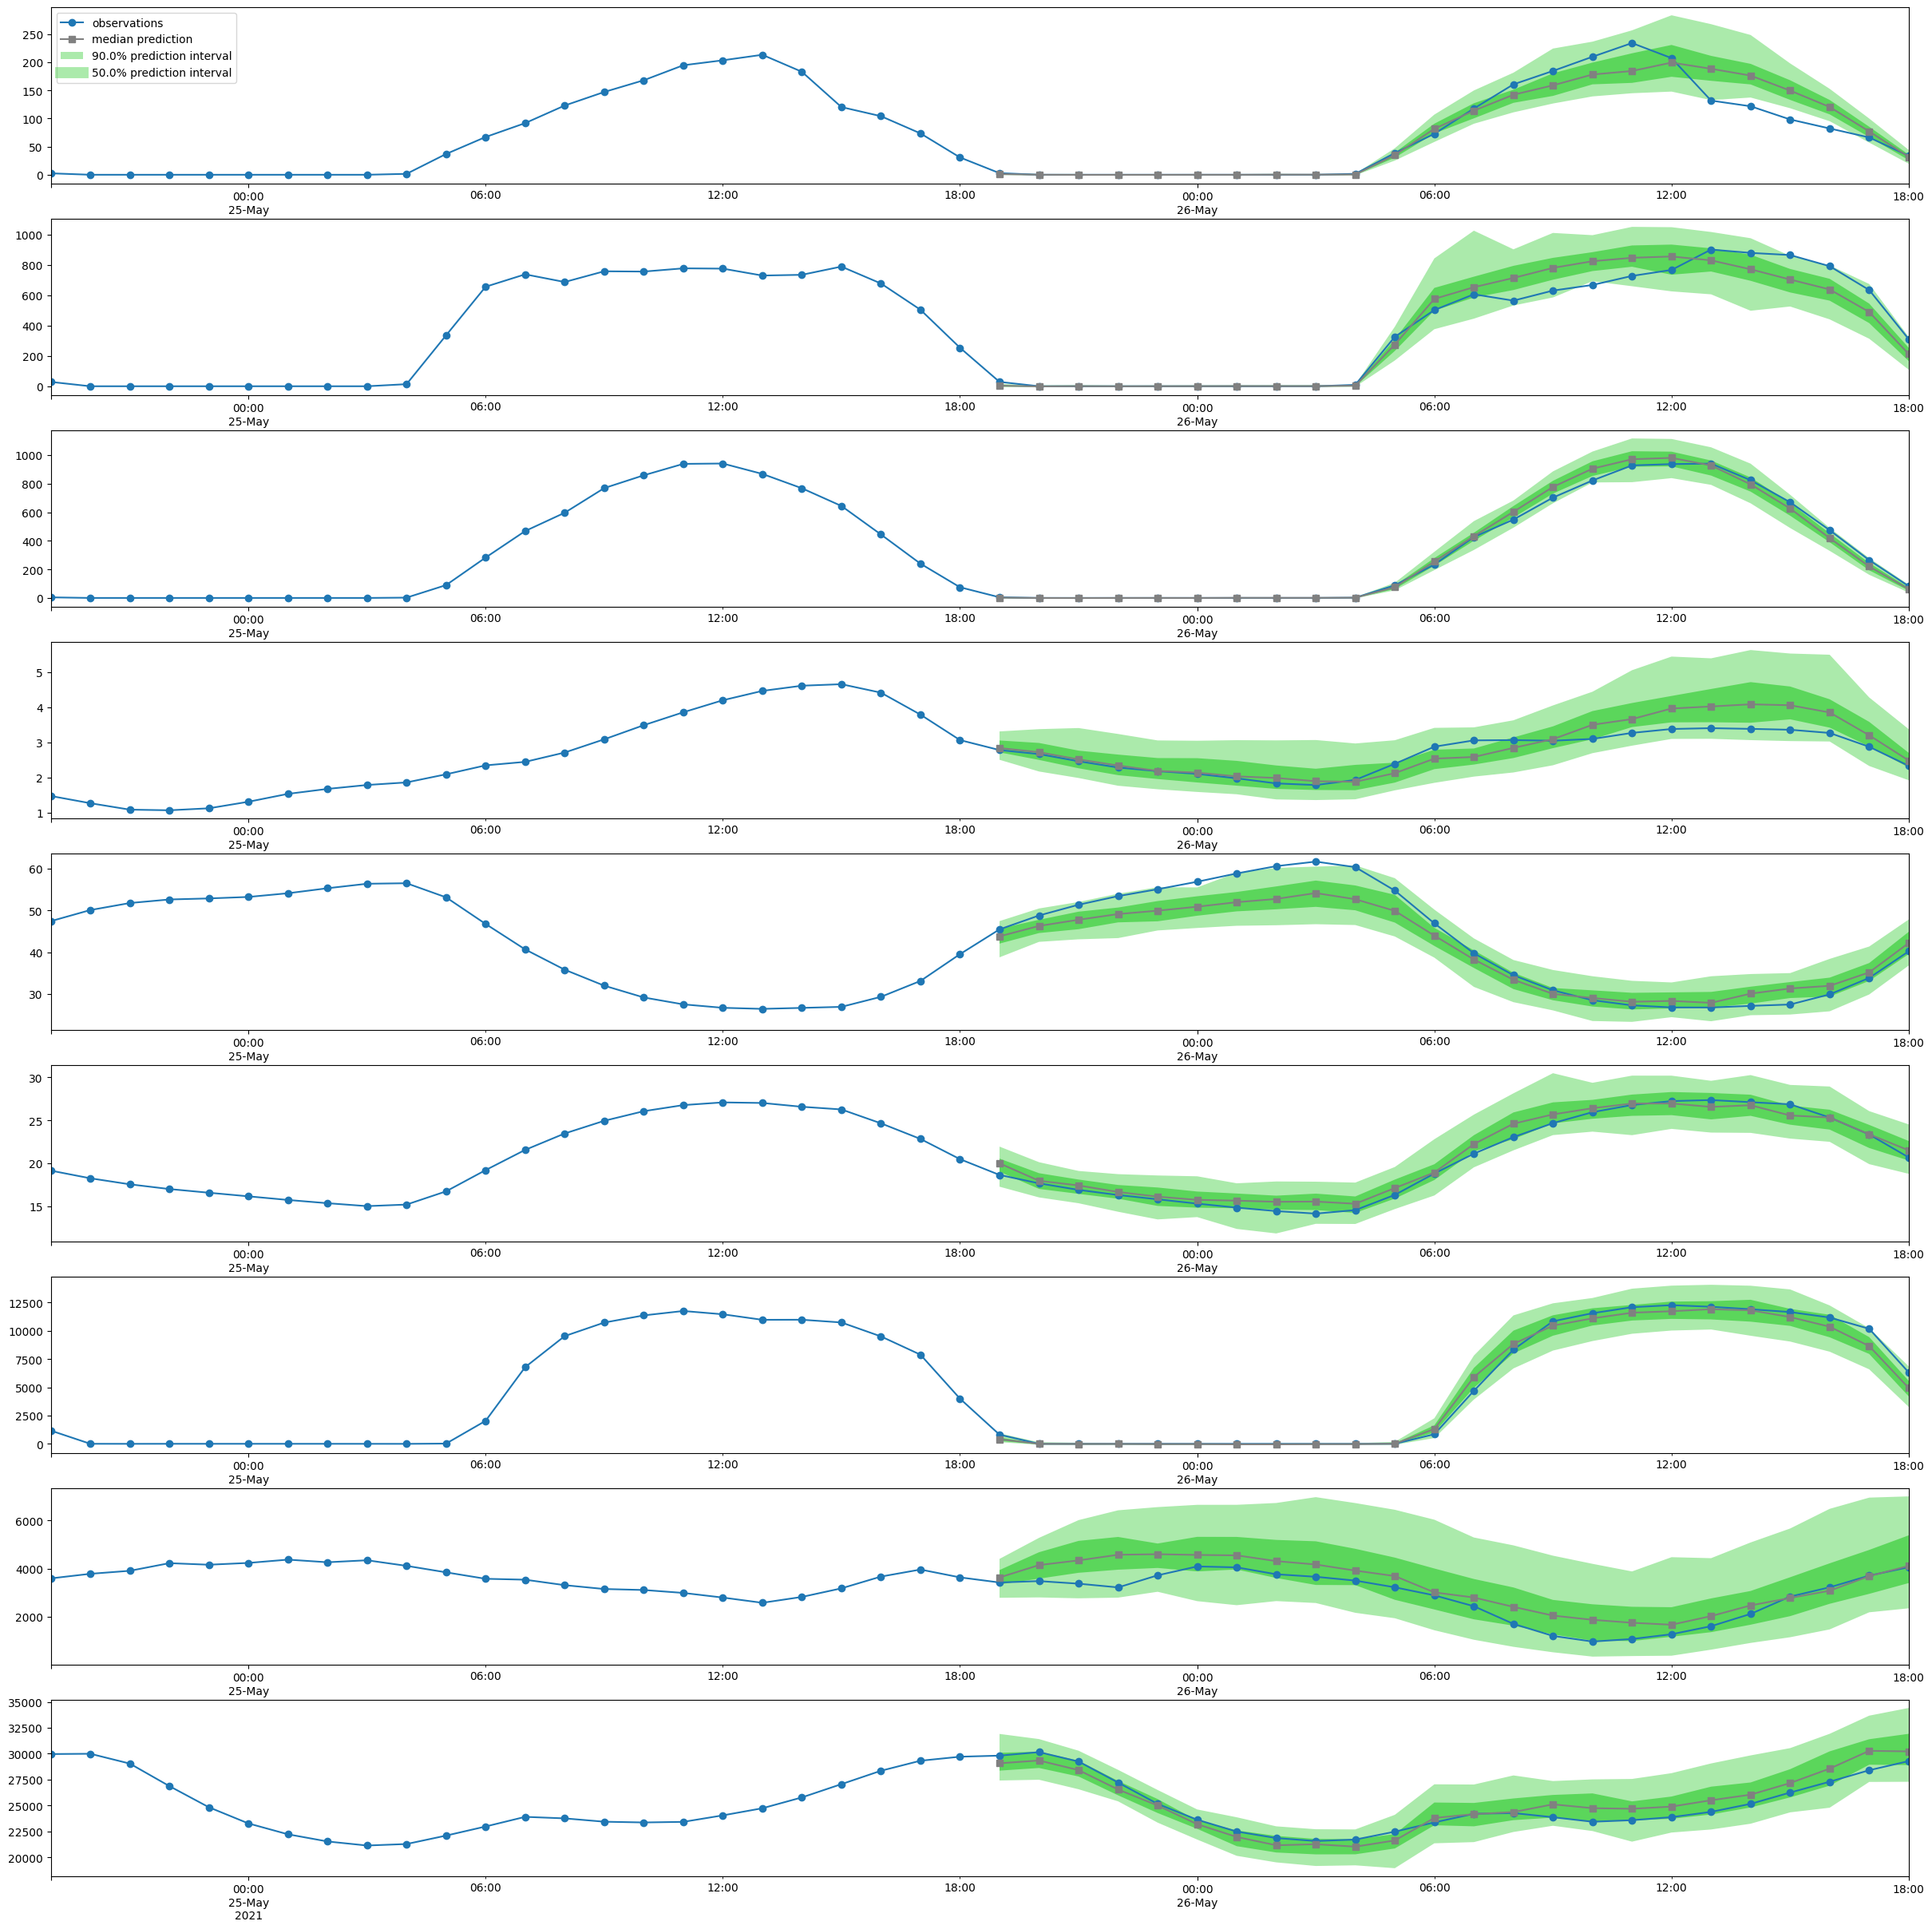

In [ ]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=H,contex_length=M,fname=f"/content/GDDPM_on_renew3_with_full_graph{M}-{H}.jpg", color="limegreen",
)
plt.show()